<a href="https://colab.research.google.com/github/snig-17/QM-GRUNGE/blob/main/visualisations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("Expedition Summaries.csv")

print(df.head())
print(df.columns)

  Year/ Season  Exped Total  Exped Succ  Pct Succ  Total Mbrs  Mbrs AbvBC   \
0      1922 Spr            1           0         0          13          12   
1      1924 Spr            1           0         0          11           9   
2      1933 Spr            1           0         0          16          16   
3      1934 Spr            1           0         0           1           1   
4      1935 Sum            1           0         0           7           7   

  Hired AbvBC  Mbrs Succ  Hired Succ  Mbrs Dead  Hired Dead   
0           30          0           0          0           7  
1           40          0           0          2           2  
2           50          0           0          0           0  
3            2          0           0          1           0  
4           16          0           0          0           0  
Index(['Year/ Season ', 'Exped Total ', 'Exped Succ ', 'Pct Succ ',
       'Total Mbrs ', 'Mbrs AbvBC ', 'Hired AbvBC ', 'Mbrs Succ ',
       'Hired Succ

In [5]:
# Strip whitespace from all column names
df.columns = df.columns.str.strip()

# Rename columns to Python-friendly names
df = df.rename(columns={
    "Year/ Season": "YearSeason",
    "Exped Total": "ExpedTotal",
    "Total Mbrs": "TotalMbrs",
    "Mbrs AbvBC": "MbrsAbvBC",
    "Hired AbvBC": "HiredAbvBC",
    "Mbrs Dead": "MbrsDead",
    "Hired Dead": "HiredDead"
})

# Drop rows where YearSeason is actually the header text
df = df[df["YearSeason"] != "Year/ Season"].copy()

In [7]:
# Split Year and Season
df[["Year", "Season"]] = df["YearSeason"].str.split(" ", expand=True)

df["Year"] = pd.to_numeric(df["Year"], errors="coerce")

# Drop rows where year could not be parsed
df = df.dropna(subset=["Year"]).copy()
df["Year"] = df["Year"].astype(int)

# Keep requested period
df = df[(df["Year"] >= 1900) & (df["Year"] <= 2025)]

In [8]:
num_cols = [
    "ExpedTotal", "TotalMbrs", "MbrsAbvBC",
    "HiredAbvBC", "MbrsDead", "HiredDead"
]

for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Replace negative or impossible values
for c in ["HiredAbvBC", "HiredDead"]:
    df.loc[df[c] < 0, c] = np.nan

In [9]:
year = (
    df.groupby("Year", as_index=False)
      .agg(
          Expeditions=("ExpedTotal", "sum"),
          HiredDeaths=("HiredDead", "sum"),
          HiredAbvBC=("HiredAbvBC", "sum"),
          MeanHiredAbvBC=("HiredAbvBC", "mean"),
      )
)

In [10]:
year["SherpaFatalityRate"] = np.where(
    year["HiredAbvBC"] > 0,
    year["HiredDeaths"] / year["HiredAbvBC"],
    np.nan
)

# 5-year rolling average for visuals
year = year.sort_values("Year")
year["Rate_roll5"] = year["SherpaFatalityRate"].rolling(
    window=5, center=True, min_periods=3
).mean()

print(year.head())


   Year  Expeditions  HiredDeaths  HiredAbvBC  MeanHiredAbvBC  \
0  1922            1          7.0        30.0            30.0   
1  1924            1          2.0        40.0            40.0   
2  1933            1          0.0        50.0            50.0   
3  1934            1          0.0         2.0             2.0   
4  1935            1          0.0        16.0            16.0   

   SherpaFatalityRate  Rate_roll5  
0            0.233333    0.094444  
1            0.050000    0.070833  
2            0.000000    0.056667  
3            0.000000    0.010000  
4            0.000000    0.000000  


In [11]:
bins = [1900, 1979, 1999, 2013, 2025]
labels = ["1900–1979", "1980–1999", "2000–2013", "2014–2025"]

year["Era"] = pd.cut(year["Year"], bins=bins, labels=labels)

desc = (
    year.groupby("Era")
        .agg(
            years=("Year", "count"),
            mean_rate=("SherpaFatalityRate", "mean"),
            median_rate=("SherpaFatalityRate", "median"),
            mean_expeditions=("Expeditions", "mean"),
            mean_hired_abvbc=("MeanHiredAbvBC", "mean")
        )
)

print(desc)


           years  mean_rate  median_rate  mean_expeditions  mean_hired_abvbc
Era                                                                         
1900–1979     29   0.025770     0.000000          1.758621         36.488506
1980–1999     20   0.015279     0.013139         23.500000         47.166667
2000–2013     14   0.002671     0.000990         79.142857        204.916667
2014–2025     11   0.009709     0.002548         63.454545        283.712121


/tmp/ipython-input-1192270672.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  year.groupby("Era")


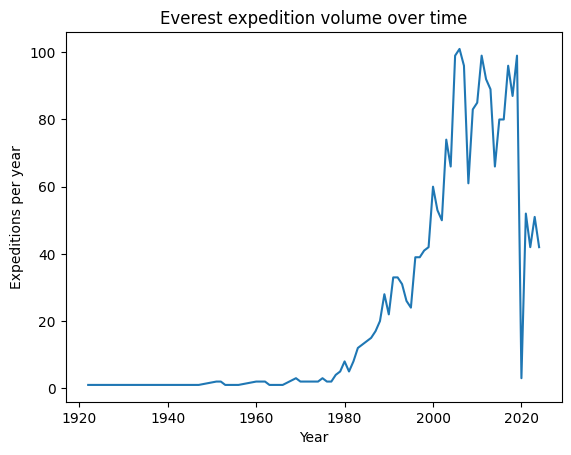

In [12]:
plt.figure()
plt.plot(year["Year"], year["Expeditions"])
plt.xlabel("Year")
plt.ylabel("Expeditions per year")
plt.title("Everest expedition volume over time")
plt.show()


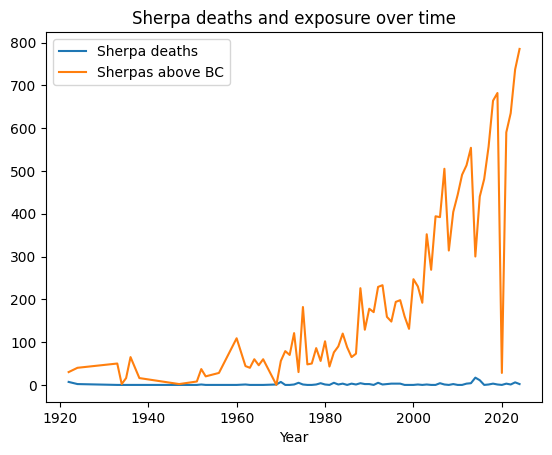

In [13]:
plt.figure()
plt.plot(year["Year"], year["HiredDeaths"], label="Sherpa deaths")
plt.plot(year["Year"], year["HiredAbvBC"], label="Sherpas above BC")
plt.xlabel("Year")
plt.title("Sherpa deaths and exposure over time")
plt.legend()
plt.show()


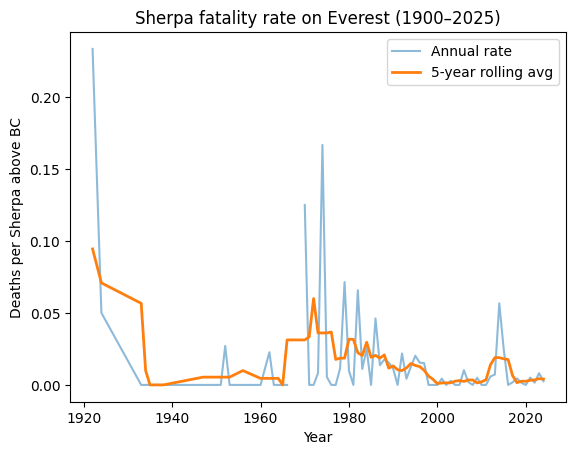

In [14]:
plt.figure()
plt.plot(year["Year"], year["SherpaFatalityRate"], alpha=0.5, label="Annual rate")
plt.plot(year["Year"], year["Rate_roll5"], linewidth=2, label="5-year rolling avg")
plt.xlabel("Year")
plt.ylabel("Deaths per Sherpa above BC")
plt.title("Sherpa fatality rate on Everest (1900–2025)")
plt.legend()
plt.show()


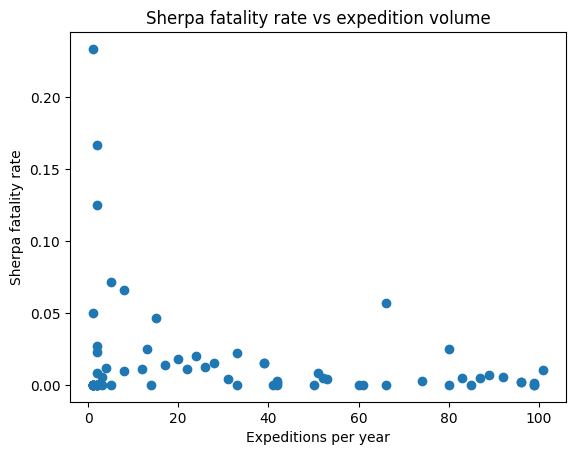

In [15]:
plt.figure()
plt.scatter(year["Expeditions"], year["SherpaFatalityRate"])
plt.xlabel("Expeditions per year")
plt.ylabel("Sherpa fatality rate")
plt.title("Sherpa fatality rate vs expedition volume")
plt.show()

Cleaned columns: ['Year/ Season', 'Exped Total', 'Exped Succ', 'Pct Succ', 'Total Mbrs', 'Mbrs AbvBC', 'Hired AbvBC', 'Mbrs Succ', 'Hired Succ', 'Mbrs Dead', 'Hired Dead']
  Year/ Season Exped Total Exped Succ Pct Succ Total Mbrs Mbrs AbvBC  \
0     1922 Spr           1          0        0         13         12   
1     1924 Spr           1          0        0         11          9   
2     1933 Spr           1          0        0         16         16   

  Hired AbvBC Mbrs Succ Hired Succ Mbrs Dead Hired Dead  
0          30         0          0         0          7  
1          40         0          0         2          2  
2          50         0          0         0          0  

Year-level preview:
   Year  Expeditions  HiredDeaths  HiredAbvBC  TotalMbrs  MbrsAbvBC  \
0  1922          1.0          7.0        30.0       13.0       12.0   
1  1924          1.0          2.0        40.0       11.0        9.0   
2  1933          1.0          0.0        50.0       16.0       16.0   
3 

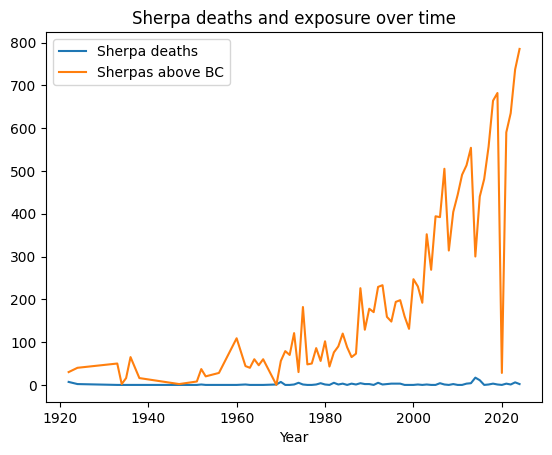

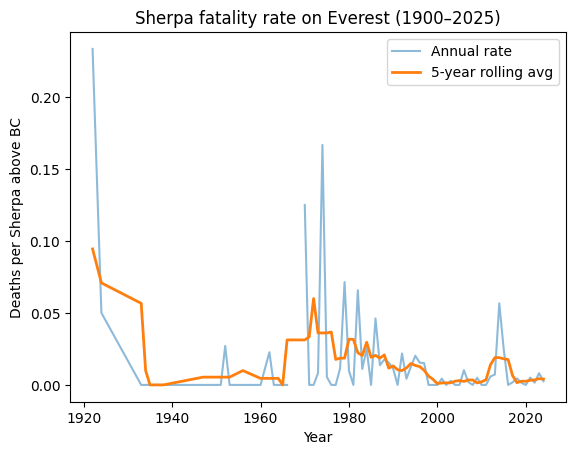

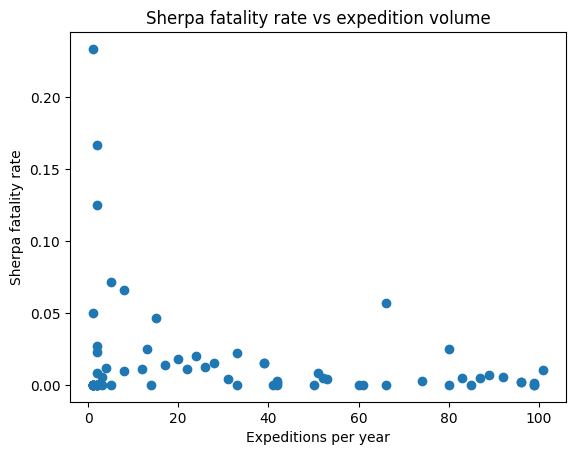

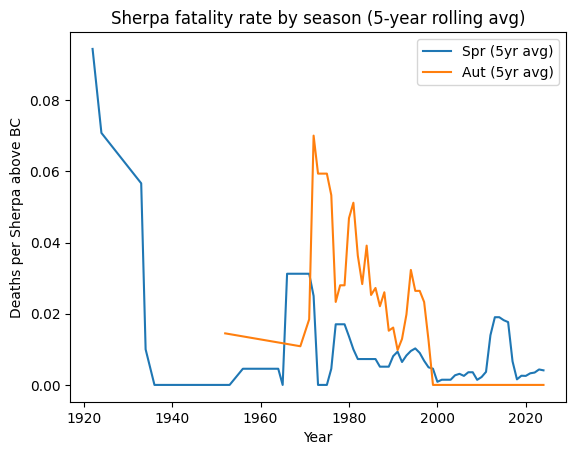

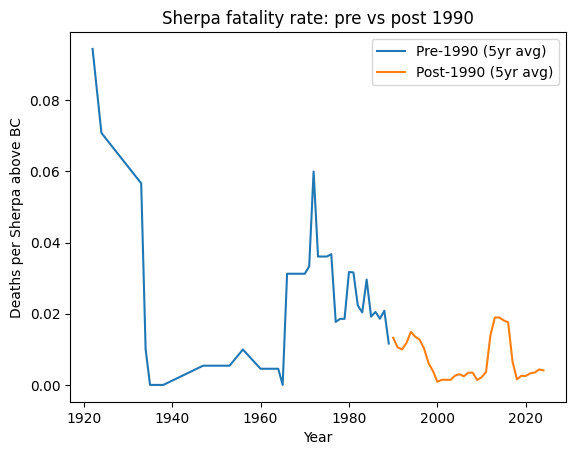

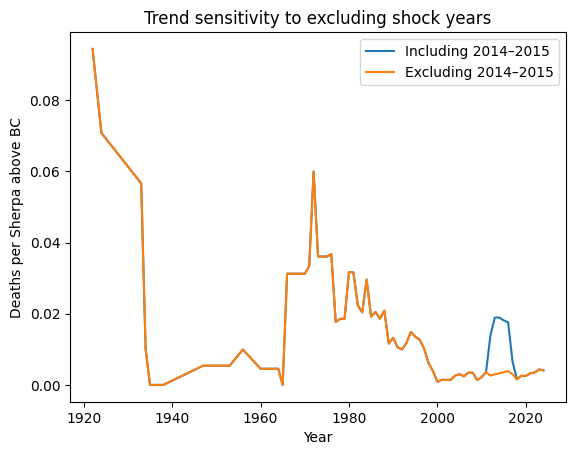

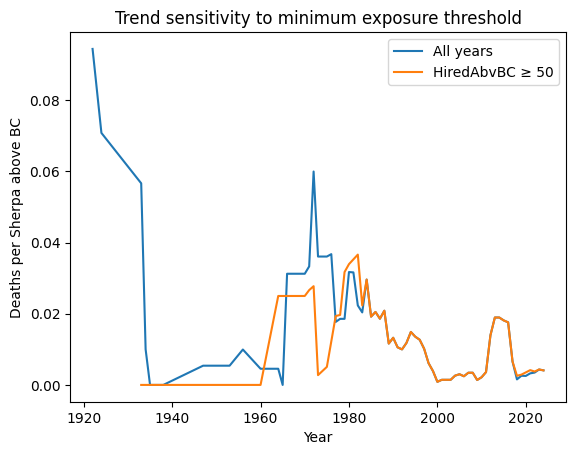

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =====================
# 0) FILE PATH
# =====================
FILEPATH = "Expedition Summaries.csv"   # <-- change if needed

# =====================
# 1) LOAD
# =====================
df = pd.read_csv(FILEPATH)
# Strip whitespace from all column names immediately after loading
df.columns = df.columns.str.strip()
print("Cleaned columns:", df.columns.tolist())
print(df.head(3))

# =====================
# 2) RENAME (based on your screenshot)
# =====================
df = df.rename(columns={
    "Year/ Season": "YearSeason",
    "Exped Total": "ExpedTotal",
    "Exped Succ": "ExpedSucc",
    "Pct Succ": "PctSucc",
    "Total Mbrs": "TotalMbrs",
    "Mbrs AbvBC": "MbrsAbvBC",
    "Hired AbvBC": "HiredAbvBC",
    "Mbrs Succ": "MbrsSucc",
    "Hired Succ": "HiredSucc",
    "Mbrs Dead": "MbrsDead",
    "Hired Dead": "HiredDead",
})

# =====================
# 3) DROP DUPLICATE HEADER ROWS (your file repeats header mid-sheet)
# =====================
# Keep only rows where YearSeason looks like "YYYY Spr" etc.
df["YearSeason"] = df["YearSeason"].astype(str)
df = df[df["YearSeason"].str.match(r"^\d{4}\s+\w+$", na=False)].copy()

# =====================
# 4) PARSE YEAR + SEASON
# =====================
df[["Year", "Season"]] = df["YearSeason"].str.split(r"\s+", n=1, expand=True)
df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
df = df.dropna(subset=["Year"]).copy()
df["Year"] = df["Year"].astype(int)

# Keep requested period
df = df[(df["Year"] >= 1900) & (df["Year"] <= 2025)].copy()

# =====================
# 5) NUMERIC CLEANING
# =====================
num_cols = [
    "ExpedTotal","ExpedSucc","PctSucc","TotalMbrs","MbrsAbvBC","HiredAbvBC",
    "MbrsSucc","HiredSucc","MbrsDead","HiredDead"
]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Replace negative values with NaN (shouldn't exist)
for c in ["ExpedTotal","TotalMbrs","MbrsAbvBC","HiredAbvBC","MbrsDead","HiredDead"]:
    if c in df.columns:
        df.loc[df[c] < 0, c] = np.nan

# Optional: drop rows with missing key risk variables
df = df.dropna(subset=["ExpedTotal", "HiredAbvBC", "HiredDead"]).copy()

# =====================
# 6) YEAR-LEVEL AGGREGATION
# =====================
year = (
    df.groupby("Year", as_index=False)
      .agg(
          Expeditions=("ExpedTotal", "sum"),
          HiredDeaths=("HiredDead", "sum"),
          HiredAbvBC=("HiredAbvBC", "sum"),
          TotalMbrs=("TotalMbrs", "sum"),
          MbrsAbvBC=("MbrsAbvBC", "sum"),
          MbrsDeaths=("MbrsDead", "sum"),
      )
      .sort_values("Year")
)

# Sherpa fatality rate (avoid divide by zero)
year["SherpaFatalityRate"] = np.where(
    year["HiredAbvBC"] > 0,
    year["HiredDeaths"] / year["HiredAbvBC"],
    np.nan
)
year["Rate_roll5"] = year["SherpaFatalityRate"].rolling(5, center=True, min_periods=3).mean()

# Optional: client fatality rate if you want later comparisons
year["ClientFatalityRate"] = np.where(
    year["MbrsAbvBC"] > 0,
    year["MbrsDeaths"] / year["MbrsAbvBC"],
    np.nan
)

print("\nYear-level preview:")
print(year.head(10))

# =====================
# 7) YEAR \u00d7 SEASON AGGREGATION (for Spring vs Autumn)
# =====================
# Check what your file uses for season labels:
print("\nUnique Season labels:", sorted(df["Season"].dropna().unique()))

# If your seasons are exactly Spr/Aut, keep those:
df_sa = df[df["Season"].isin(["Spr", "Aut"])].copy()

ys = (
    df_sa.groupby(["Year", "Season"], as_index=False)
         .agg(
             Expeditions=("ExpedTotal", "sum"),
             HiredDeaths=("HiredDead", "sum"),
             HiredAbvBC=("HiredAbvBC", "sum"),
         )
         .sort_values(["Season", "Year"])
)

ys["SherpaFatalityRate"] = np.where(
    ys["HiredAbvBC"] > 0,
    ys["HiredDeaths"] / ys["HiredAbvBC"],
    np.nan
)

ys["Rate_roll5"] = (
    ys.groupby("Season")["SherpaFatalityRate"]
      .transform(lambda s: s.rolling(5, center=True, min_periods=3).mean())
)

# =====================
# 8) PLOTS: BASE DESCRIPTIVES
# =====================

# Plot 1: Sherpa deaths vs exposure
plt.figure()
plt.plot(year["Year"], year["HiredDeaths"], label="Sherpa deaths")
plt.plot(year["Year"], year["HiredAbvBC"], label="Sherpas above BC")
plt.xlabel("Year")
plt.title("Sherpa deaths and exposure over time")
plt.legend()
plt.show()

# Plot 2: Sherpa fatality rate (annual + rolling)
plt.figure()
plt.plot(year["Year"], year["SherpaFatalityRate"], alpha=0.5, label="Annual rate")
plt.plot(year["Year"], year["Rate_roll5"], linewidth=2, label="5-year rolling avg")
plt.xlabel("Year")
plt.ylabel("Deaths per Sherpa above BC")
plt.title("Sherpa fatality rate on Everest (1900\u20132025)")
plt.legend()
plt.show()

# Plot 3: Rate vs expedition volume
plt.figure()
plt.scatter(year["Expeditions"], year["SherpaFatalityRate"])
plt.xlabel("Expeditions per year")
plt.ylabel("Sherpa fatality rate")
plt.title("Sherpa fatality rate vs expedition volume")
plt.show()

# =====================
# 9) SPLITS YOU ASKED FOR
# =====================

# 9A) Spring vs Autumn (rolling)
plt.figure()
for s in ["Spr", "Aut"]:
    d = ys[ys["Season"] == s]
    if len(d) > 0:
        plt.plot(d["Year"], d["Rate_roll5"], label=f"{s} (5yr avg)")
plt.xlabel("Year")
plt.ylabel("Deaths per Sherpa above BC")
plt.title("Sherpa fatality rate by season (5-year rolling avg)")
plt.legend()
plt.show()

# 9B) Pre/post cutoff (choose 1990 or 2000)
cutoff = 1990  # <-- change to 2000 if you prefer
pre = year[year["Year"] < cutoff].copy()
post = year[year["Year"] >= cutoff].copy()

plt.figure()
plt.plot(pre["Year"], pre["Rate_roll5"], label=f"Pre-{cutoff} (5yr avg)")
plt.plot(post["Year"], post["Rate_roll5"], label=f"Post-{cutoff} (5yr avg)")
plt.xlabel("Year")
plt.ylabel("Deaths per Sherpa above BC")
plt.title(f"Sherpa fatality rate: pre vs post {cutoff}")
plt.legend()
plt.show()

# 9C) Excluding shock years (2014, 2015) vs including
shock_years = [2014, 2015]

year_incl = year.copy()
year_excl = year[~year["Year"].isin(shock_years)].copy().sort_values("Year")
year_excl["Rate_roll5"] = year_excl["SherpaFatalityRate"].rolling(5, center=True, min_periods=3).mean()

plt.figure()
plt.plot(year_incl["Year"], year_incl["Rate_roll5"], label="Including 2014\u20132015")
plt.plot(year_excl["Year"], year_excl["Rate_roll5"], label="Excluding 2014\u20132015")
plt.xlabel("Year")
plt.ylabel("Deaths per Sherpa above BC")
plt.title("Trend sensitivity to excluding shock years")
plt.legend()
plt.show()

# 9D) Minimum exposure filter (reduce early-year noise)
min_exposure = 50  # try 20, 50, 100
year_filt = year[year["HiredAbvBC"] >= min_exposure].copy().sort_values("Year")
year_filt["Rate_roll5"] = year_filt["SherpaFatalityRate"].rolling(5, center=True, min_periods=3).mean()

plt.figure()
plt.plot(year["Year"], year["Rate_roll5"], label="All years")
plt.plot(year_filt["Year"], year_filt["Rate_roll5"], label=f"HiredAbvBC \u2265 {min_exposure}")
plt.xlabel("Year")
plt.ylabel("Deaths per Sherpa above BC")
plt.title("Trend sensitivity to minimum exposure threshold")
plt.legend()
plt.show()

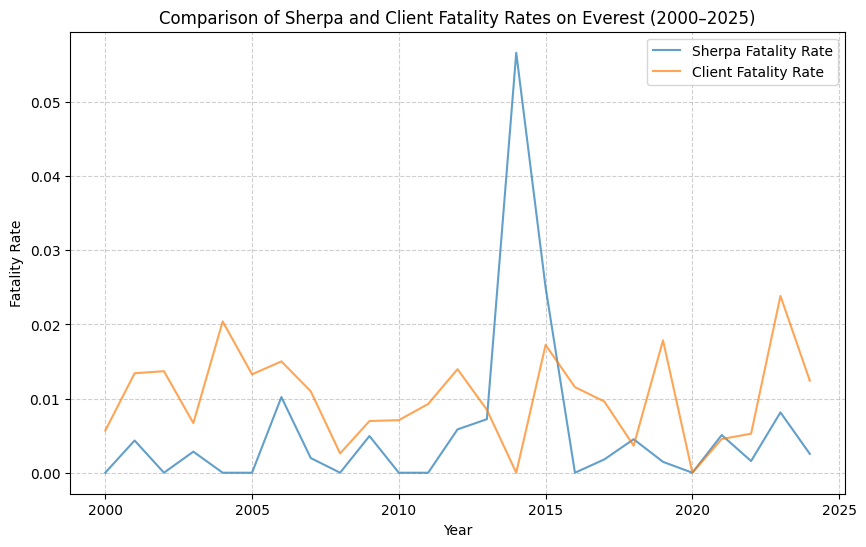

In [25]:
year_2000_onwards = year[year["Year"] >= 2000].copy()

plt.figure(figsize=(10, 6))
plt.plot(year_2000_onwards["Year"], year_2000_onwards["SherpaFatalityRate"], label="Sherpa Fatality Rate", alpha=0.7)
plt.plot(year_2000_onwards["Year"], year_2000_onwards["ClientFatalityRate"], label="Client Fatality Rate", alpha=0.7)
plt.xlabel("Year")
plt.ylabel("Fatality Rate")
plt.title("Comparison of Sherpa and Client Fatality Rates on Everest (2000–2025)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### Sherpa Fatality Rate (Annual Only)

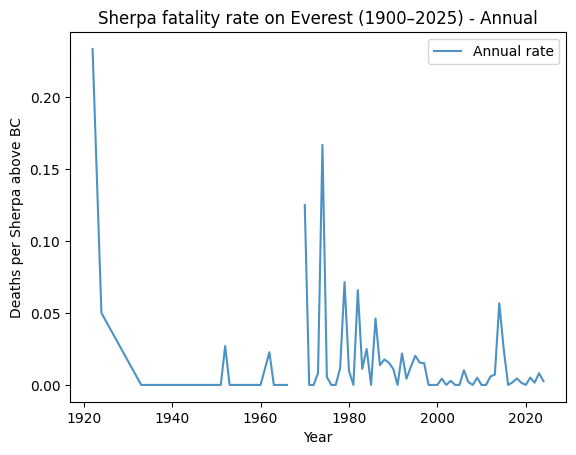

In [18]:
plt.figure()
plt.plot(year["Year"], year["SherpaFatalityRate"], alpha=0.8, label="Annual rate")
plt.xlabel("Year")
plt.ylabel("Deaths per Sherpa above BC")
plt.title("Sherpa fatality rate on Everest (1900–2025) - Annual")
plt.legend()
plt.show()

### Sherpa Fatality Rate by Season (Annual, without rolling average)

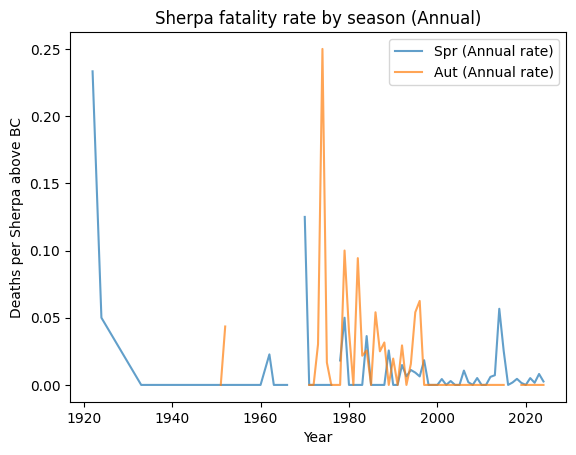

In [19]:
plt.figure()
for s in ["Spr", "Aut"]:
    d = ys[ys["Season"] == s]
    if len(d) > 0:
        plt.plot(d["Year"], d["SherpaFatalityRate"], alpha=0.7, label=f"{s} (Annual rate)")
plt.xlabel("Year")
plt.ylabel("Deaths per Sherpa above BC")
plt.title("Sherpa fatality rate by season (Annual)")
plt.legend()
plt.show()

### Sherpa Fatality Rate: Pre vs Post Cutoff (Annual, without rolling average)

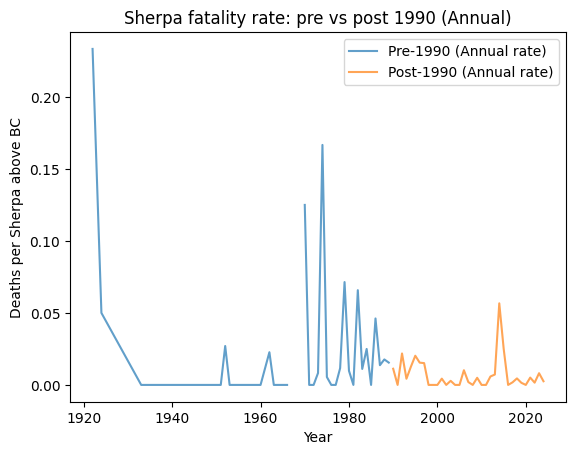

In [20]:
cutoff = 1990  # Using the same cutoff as before
pre = year[year["Year"] < cutoff].copy()
post = year[year["Year"] >= cutoff].copy()

plt.figure()
plt.plot(pre["Year"], pre["SherpaFatalityRate"], alpha=0.7, label=f"Pre-{cutoff} (Annual rate)")
plt.plot(post["Year"], post["SherpaFatalityRate"], alpha=0.7, label=f"Post-{cutoff} (Annual rate)")
plt.xlabel("Year")
plt.ylabel("Deaths per Sherpa above BC")
plt.title(f"Sherpa fatality rate: pre vs post {cutoff} (Annual)")
plt.legend()
plt.show()

### Trend Sensitivity to Excluding Shock Years (Annual, without rolling average)

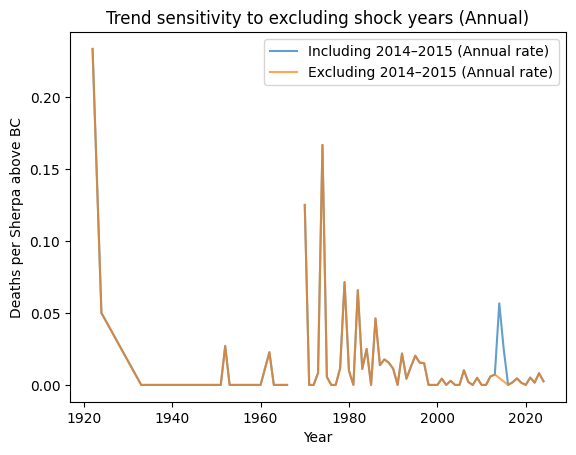

In [21]:
shock_years = [2014, 2015]

year_incl = year.copy()
year_excl = year[~year["Year"].isin(shock_years)].copy().sort_values("Year")

plt.figure()
plt.plot(year_incl["Year"], year_incl["SherpaFatalityRate"], alpha=0.7, label="Including 2014–2015 (Annual rate)")
plt.plot(year_excl["Year"], year_excl["SherpaFatalityRate"], alpha=0.7, label="Excluding 2014–2015 (Annual rate)")
plt.xlabel("Year")
plt.ylabel("Deaths per Sherpa above BC")
plt.title("Trend sensitivity to excluding shock years (Annual)")
plt.legend()
plt.show()

### Trend Sensitivity to Minimum Exposure Threshold (Annual, without rolling average)

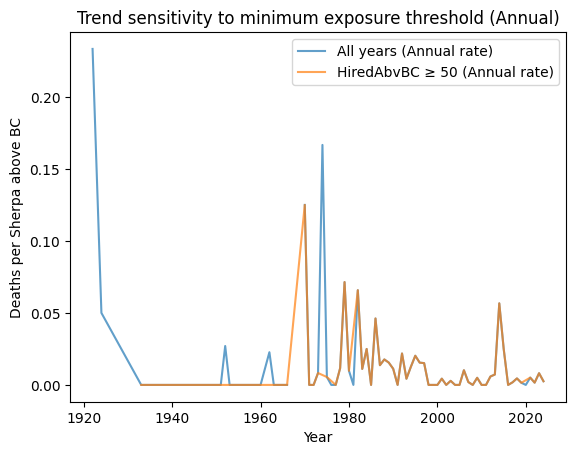

In [22]:
min_exposure = 50  # Using the same minimum exposure as before
year_filt = year[year["HiredAbvBC"] >= min_exposure].copy().sort_values("Year")

plt.figure()
plt.plot(year["Year"], year["SherpaFatalityRate"], alpha=0.7, label="All years (Annual rate)")
plt.plot(year_filt["Year"], year_filt["SherpaFatalityRate"], alpha=0.7, label=f"HiredAbvBC ≥ {min_exposure} (Annual rate)")
plt.xlabel("Year")
plt.ylabel("Deaths per Sherpa above BC")
plt.title("Trend sensitivity to minimum exposure threshold (Annual)")
plt.legend()
plt.show()

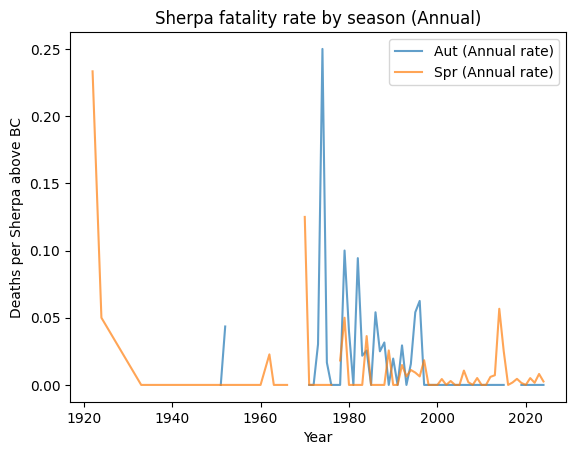

In [23]:
plt.figure()
for s in ys["Season"].dropna().unique():
    d = ys[ys["Season"] == s]
    if len(d) > 0:
        plt.plot(d["Year"], d["SherpaFatalityRate"], alpha=0.7, label=f"{s} (Annual rate)")
plt.xlabel("Year")
plt.ylabel("Deaths per Sherpa above BC")
plt.title("Sherpa fatality rate by season (Annual)")
plt.legend()
plt.show()